In [73]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [182]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from hyperopt import hp, tpe, fmin, Trials
from tqdm import tqdm
# from tqdm.notebook import tqdm

from collections import OrderedDict
import itertools
from functools import partial
import datetime
from joblib import Parallel, delayed

from models.seir.seir_testing import SEIR_Testing
from data.dataloader import get_global_data, get_indian_data
from data.bbmp_dataloader import loadbbmpdata
from utils.plotting import create_plots
from utils.generic import init_params

## Load BBMP Data

In [75]:
df, df_agg = loadbbmpdata('bbmp-raw.csv')
df_agg = df_agg.iloc[9:-3, :]
df_agg.reset_index(drop=True, inplace=True)

In [20]:
df_agg = pd.read_csv('../../data/data/bbmp-processed-13-04.csv')
df_agg['Date'] = pd.to_datetime(df_agg['Date'])
df_agg = df_agg.iloc[7:, :]
df_agg.reset_index(drop=True, inplace=True)

## Create Train-Val Split

In [179]:
df_train = df_agg.iloc[:-10, :]
df_val = df_agg.iloc[-10:, :]
df_agg

,Date,Active Infections (Unknown),Hospitalised,On ICU,On Ventilator,Fatalities,Total Infected,Total Infected (Unknown),Recovered
0,2020-03-08,7,3,0,0,0,3,7,0
1,2020-03-09,5,4,0,0,0,4,8,0
2,2020-03-10,6,4,0,0,0,4,10,0
3,2020-03-11,7,5,0,0,0,5,11,0
4,2020-03-12,7,5,0,0,0,5,12,0
5,2020-03-13,8,5,0,0,0,5,13,0
6,2020-03-14,10,5,0,0,0,5,15,0
7,2020-03-15,15,6,0,0,0,6,20,0
8,2020-03-16,17,8,0,0,0,8,23,0
9,2020-03-17,16,13,0,0,0,13,24,0


## Loss Calculation Functions

In [68]:
def _calc_rmse(y_pred, y_true, log=True):
    if log:
        y_true = np.log(y_true)
        y_pred = np.log(y_pred)
    loss = np.sqrt(np.mean((y_true - y_pred)**2))
    return loss

def _calc_mape(y_pred, y_true):
#     import pdb; pdb.set_trace()
    y_pred = y_pred[y_true > 0]
    y_true = y_true[y_true > 0]

    ape = np.abs((y_true - y_pred + 0) / y_true) *  100
    loss = np.mean(ape)
    return loss

def calc_loss_dict(states_time_matrix, df, method='rmse', rmse_log=False):
    pred_hospitalisations = states_time_matrix[6] + states_time_matrix[7] + states_time_matrix[8]
    pred_recoveries = states_time_matrix[9]
    pred_fatalities = states_time_matrix[10]
    pred_infectious_unknown = states_time_matrix[2] + states_time_matrix[4]
    pred_total_cases = pred_hospitalisations + pred_recoveries + pred_fatalities
    
    if method == 'rmse':
        if rmse_log:
            calculate = lambda x, y : _calc_rmse(x, y)
        else:
            calculate = lambda x, y : _calc_rmse(x, y, log=False)
    
    if method == 'mape':
            calculate = lambda x, y : _calc_mape(x, y)
    
    losses = {}
    losses['hospitalised'] = calculate(pred_hospitalisations, df['Hospitalised'])
    losses['recovered'] = calculate(pred_recoveries, df['Recovered'])
    losses['fatalities'] = calculate(pred_fatalities, df['Fatalities'])
    losses['active_infections'] = calculate(pred_infectious_unknown, df['Active Infections (Unknown)'])
    losses['total'] = calculate(pred_total_cases, df['Total Infected'])
    
    return losses

def calc_loss(states_time_matrix, df, method='rmse', rmse_log=False):
    losses = calc_loss_dict(states_time_matrix, df, method, rmse_log)
    loss = losses['hospitalised'] + losses['recovered'] + losses['total'] + losses['active_infections']
    return loss

## Fitting Helper Functions

In [106]:
def get_country_dataframe(df_master, country):
    df_country = df_master[df_master['Country/Region'] == country].loc[:, 'Date':].groupby('Date').sum().reset_index()
    df_country = df_country[df_country['ConfirmedCases'] > 0]
    total_days = len(df_country['Date'])
    df_country.reset_index(drop=True, inplace=True)
    return df_country

def solve_and_compute_loss(variable_params, default_params, df, total_days, method='rmse'):
    params_dict = {**variable_params, **default_params}
    vanilla_params, testing_params, state_init_values = init_params(**params_dict)
    solver = SEIR_Testing(vanilla_params, testing_params, state_init_values)
    sol = solver.solve_ode(total_no_of_days=total_days - 1, time_step=1, method='Radau')
    states_time_matrix = (sol.y*vanilla_params['N']).astype('int')
    return calc_loss(states_time_matrix[:, -20:-10], df.iloc[-20:-10, :], method)

def _create_dict(param_names, values):
    params_dict = {param_names[i]: values[i] for i in range(len(values))}
    return params_dict

## Fitting Functions

In [166]:
def gridsearch(df_true, place='Bangalore', N=1e7, offset=0, lockdown_date='2020-03-25', lockdown_removal_date='2020-05-03'):
    if place == 'Italy':
        df_true = get_country_dataframe(df_true, place)
        
    df_true_fitting = df_true.loc[offset:, :]
    df_true_fitting.reset_index(drop=True, inplace=True)
    
    total_days = len(df_true_fitting['Date'])
    init_infected = max(df_true_fitting.loc[0, 'Total Infected'], 1)
    start_date = df_true_fitting.loc[0, 'Date']
    intervention_date = datetime.datetime.strptime(lockdown_date, '%Y-%m-%d')
    lockdown_removal_date = datetime.datetime.strptime(lockdown_removal_date, '%Y-%m-%d')
    
    default_params = {
        'N' : N,
        'init_infected' : init_infected,
        'intervention_day' : (intervention_date - start_date).days,
        'lockdown_removal_day' : (lockdown_removal_date - start_date).days,
        'T_hosp' : 0.001,
        'P_fatal' : 0.01
    }
    
    param_ranges = {
        'R0' : np.linspace(1.8, 3, 13),
        'T_inc' : np.linspace(3, 5, 5),
        'T_inf' : np.linspace(2.5, 3.5, 5),
        'T_recov_severe' : np.linspace(11, 15, 10),
        'P_severe' : np.linspace(0.3, 0.9, 25),
        'intervention_amount' : np.linspace(0.4, 1, 31)
    }
    
    rangelists = list(param_ranges.values())
    cartesian_product_tuples = itertools.product(*rangelists)
    list_of_param_dicts = [_create_dict(list(param_ranges.keys()), values) for values in cartesian_product_tuples]
    
    loss_array = Parallel(n_jobs=40)(delayed(solve_and_compute_loss)(params_dict, default_params, df_true_fitting, total_days) for params_dict in tqdm(list_of_param_dicts))
                
    return loss_array, list_of_param_dicts, df_true, df_true_fitting

def bayes_opt(df_true, place='Bangalore', N=1e7, offset=0, lockdown_date='2020-03-25', lockdown_removal_date='2020-05-03', method='rmse'):
    if place == 'Italy':
        df_true = get_country_dataframe(df_true, place)
        
    df_true_fitting = df_true.loc[offset:, :]
    df_true_fitting.reset_index(drop=True, inplace=True)
    
    total_days = len(df_true_fitting['Date'])
    init_infected = max(df_true_fitting.loc[0, 'Total Infected'], 1)
    start_date = df_true_fitting.loc[0, 'Date']
    intervention_date = datetime.datetime.strptime(lockdown_date, '%Y-%m-%d')
    lockdown_removal_date = datetime.datetime.strptime(lockdown_removal_date, '%Y-%m-%d')
    
    variable_params = {
        'R0' : hp.uniform('R0', 1.6, 3),
        'T_inc' : hp.uniform('T_inc', 4, 5),
        'T_inf' : hp.uniform('T_inf', 3, 4),
        'T_recov_severe' : hp.uniform('T_recov_severe', 9, 20),
        'P_severe' : hp.uniform('P_severe', 0.3, 0.99),
        'intervention_amount' : hp.uniform('intervention_amount', 0.3, 1)
    }
    
    default_params = {
        'N' : N,
        'init_infected' : init_infected,
        'intervention_day' : (intervention_date - start_date).days,
        'lockdown_removal_day' : (lockdown_removal_date - start_date).days,
        'T_hosp' : 0.001,
        'P_fatal' : 0.02
    }
    
    partial_solve_and_compute_loss = partial(solve_and_compute_loss, default_params = default_params, df=df_true_fitting, total_days=total_days, 
                                            method = method) 
    
    searchspace = variable_params
    
    trials = Trials()
    best = fmin(partial_solve_and_compute_loss,
                space=searchspace,
                algo=tpe.suggest,
                max_evals=3500,
                trials=trials)
    
    return best, trials, default_params


## Fitting

In [36]:
loss_array, list_of_param_dicts, df_country, df_country_fitting = gridsearch(df_agg, offset=9)




  0%|          | 0/3487500 [00:00<?, ?it/s]


  0%|          | 40/3487500 [00:05<130:03:37,  7.45it/s]


  0%|          | 80/3487500 [00:06<99:05:55,  9.78it/s] 


  0%|          | 120/3487500 [00:06<70:35:55, 13.72it/s]


  0%|          | 160/3487500 [00:06<50:09:40, 19.31it/s]


  0%|          | 200/3487500 [00:06<36:12:23, 26.75it/s]


  0%|          | 240/3487500 [00:07<26:09:31, 37.03it/s]


  0%|          | 360/3487500 [00:07<18:45:25, 51.64it/s]


  0%|          | 440/3487500 [00:07<13:31:47, 71.59it/s]


  0%|          | 520/3487500 [00:07<9:51:37, 98.23it/s] 


  0%|          | 680/3487500 [00:07<7:13:36, 134.02it/s]


  0%|          | 840/3487500 [00:07<5:17:28, 183.04it/s]


  0%|          | 1320/3487500 [00:07<3:48:11, 254.63it/s]


  0%|          | 1640/3487500 [00:08<2:50:07, 341.49it/s]


  0%|          | 1960/3487500 [00:08<2:08:08, 453.33it/s]


  0%|          | 2280/3487500 [00:08<1:41:00, 575.07it/s]


  0%|          | 2600/3487500 [00:08<1:17:40, 747.78it/s]


  

In [167]:
best, trials, default_params = bayes_opt(df_agg, offset=0, method='rmse')

100%|██████████| 3500/3500 [03:46<00:00, 15.44trial/s, best loss: 25.995927601834495]


In [168]:
print(best)
# print(best2)
# print(best3)

{'P_severe': 0.9893642376871511, 'R0': 2.1660326332082076, 'T_inc': 4.019151538066335, 'T_inf': 3.0002466828052077, 'T_recov_severe': 9.234978071946955, 'intervention_amount': 0.3000506562762212}


In [180]:
print(default_params)

{'N': 10000000.0, 'init_infected': 3, 'intervention_day': 17, 'lockdown_removal_day': 56, 'T_hosp': 0.001, 'P_fatal': 0.02}


## Post Fitting Evaluation + Plotting

In [75]:
def evaluate_losses(best, default_params, df_train, df_val):
    start_date = df_train.iloc[0, 0]
    simulate_till = df_val.iloc[-1, 0]
    total_no_of_days = (simulate_till - start_date).days + 1
    no_of_train_days = (df_train.iloc[-1, 0] - start_date).days + 1
    no_of_val_days = total_no_of_days - no_of_train_days
    
    final_params = {**best, **default_params}
    vanilla_params, testing_params, state_init_values = init_params(**final_params)
    solver = SEIR_Testing(vanilla_params, testing_params, state_init_values)
    sol = solver.solve_ode(total_no_of_days=total_no_of_days - 1, time_step=1, method='Radau')
    states_time_matrix = (sol.y*vanilla_params['N']).astype('int')

    train_output = states_time_matrix[:, :no_of_train_days]
    val_output = states_time_matrix[:, -no_of_val_days:]
    
    rmse_loss = calc_loss_dict(train_output, df_train, method='rmse')
    rmse_loss = pd.DataFrame.from_dict(rmse_loss, orient='index', columns=['rmse'])
    
    mape_loss = calc_loss_dict(train_output, df_train, method='mape')
    mape_loss = pd.DataFrame.from_dict(mape_loss, orient='index', columns=['mape'])
    
    train_losses = pd.concat([rmse_loss, mape_loss], axis=1)
    
    pred_hospitalisations = val_output[6] + val_output[7] + val_output[8]
    pred_recoveries = val_output[9]
    pred_fatalities = val_output[10]
    pred_infectious_unknown = val_output[2] + val_output[4]
    pred_total_cases = pred_hospitalisations + pred_recoveries + pred_fatalities
    print('Pred', pred_hospitalisations, pred_total_cases)
    print('True', df_val['Hospitalised'].to_numpy(), df_val['Total Infected'].to_numpy())
    
    rmse_loss = calc_loss_dict(val_output, df_val, method='rmse')
    rmse_loss = pd.DataFrame.from_dict(rmse_loss, orient='index', columns=['rmse'])
    
    mape_loss = calc_loss_dict(val_output, df_val, method='mape')
    mape_loss = pd.DataFrame.from_dict(mape_loss, orient='index', columns=['mape'])
    
    val_losses = pd.concat([rmse_loss, mape_loss], axis=1)
    
    print(train_losses)
    print(val_losses)
    
    return train_losses, val_losses

In [200]:
# best3['R0'] = 2.12
train_losses, val_losses = evaluate_losses(best3, default_params, df_train, df_val)

Pred [40 41 42 43 43 44 44 44 44 44] [55 58 60 63 64 67 68 70 72 73]
True [46 44 44 46 48 51 52 51 50 44] [56 59 62 64 66 69 72 75 75 75]
                        rmse       mape
hospitalised       10.664930  44.786678
recovered           1.699673  36.599702
fatalities          0.000000        NaN
active_infections   8.576454  60.820698
total               9.723968  40.272921
                       rmse        mape
hospitalised       5.300943    9.618112
recovered          3.114482   16.255556
fatalities         0.316228  100.000000
active_infections  2.345208   20.138889
total              2.626785    3.308668


In [45]:
def evaluate_top_params(loss_array, list_of_param_dicts, df_country, df_country_fitting, num_samples=1000, lockdown_removal_date='2020-04-30', 
                        simulate_till = '2020-04-30'):
    
    start_date = df_country_fitting.loc[0, 'Date']
    lockdown_removal_date = datetime.datetime.strptime(lockdown_removal_date, '%Y-%m-%d')
    simulate_till = datetime.datetime.strptime(simulate_till, '%Y-%m-%d')
    new_params = {
        'lockdown_removal_day' : (lockdown_removal_date - start_date).days
    }

    indices = np.argsort(loss_array)[:num_samples]
    columns = ['Date']+list(map(lambda x : str(x), np.arange(11)))
    df_predictions = pd.DataFrame(columns = columns)

    for idx in indices:
        
        daterange = pd.date_range(start=start_date, end=simulate_till)
        
        
        data = np.concatenate((daterange.to_numpy().reshape(-1, 1), states_time_matrix.T.astype('object')), axis=1)
        df = pd.DataFrame(data=data, columns=columns)
        df_predictions = pd.concat([df_predictions, df])

    df_predictions['Date'] = pd.to_datetime(df_predictions['Date'])
    df_predictions['hospitalised'] = (df_predictions['6'] + df_predictions['7'] + df_predictions['8']).astype('int')
    df_predictions['recoveries'] = (df_predictions['9']).astype('int')
    df_predictions['fatalities'] = (df_predictions['10']).astype('int')
    df_predictions['infectious_unknown'] = (df_predictions['2'] + df_predictions['4']).astype('int')
    df_predictions['total_cases'] = (df_predictions['hospitalised'] + df_predictions['recoveries'] + df_predictions['fatalities']).astype('int')
    
    return df_predictions

In [ ]:
df_predictions = evaluate_top_params(loss_array, list_of_param_dicts, df_country, df_country_fitting, 
                                     num_samples=1000, lockdown_removal_date='2020-04-30', simulate_till = '2020-05-15')

df_predictions1 = evaluate_top_params(loss_array, list_of_param_dicts, df_country, df_country_fitting, 
                                     num_samples=1000, lockdown_removal_date='2020-04-14', simulate_till = '2020-05-15')

df_predictions2 = evaluate_top_params(loss_array, list_of_param_dicts, df_country, df_country_fitting, 
                                     num_samples=1000, lockdown_removal_date='2020-05-15', simulate_till = '2020-05-15')

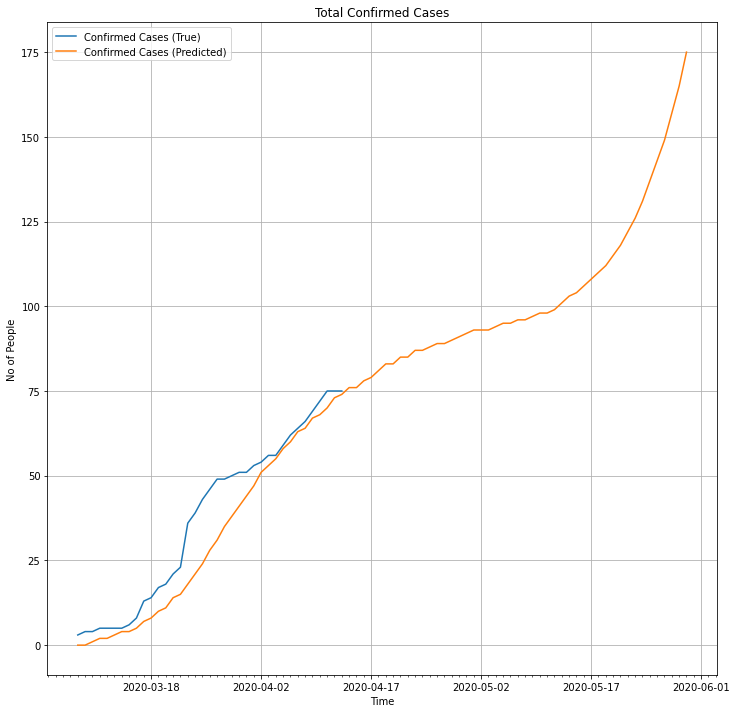

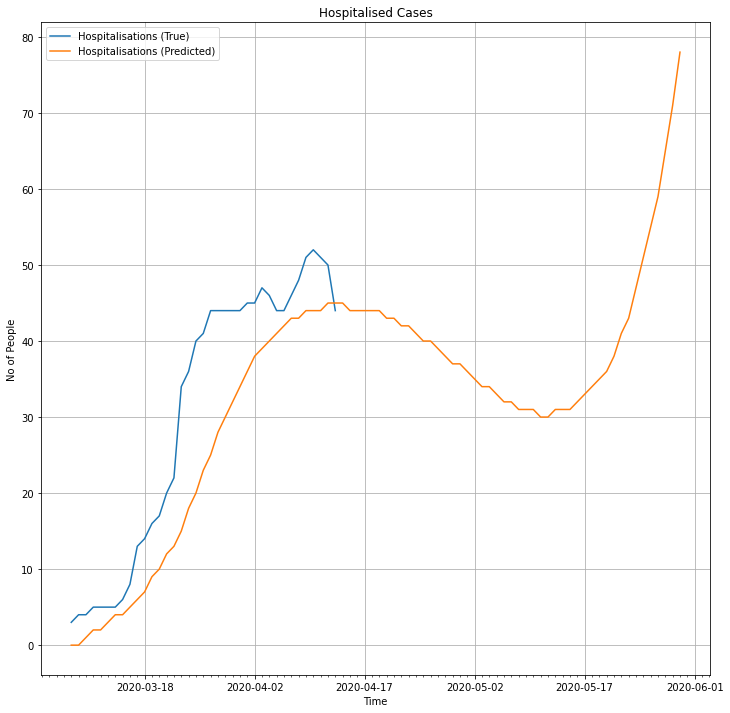

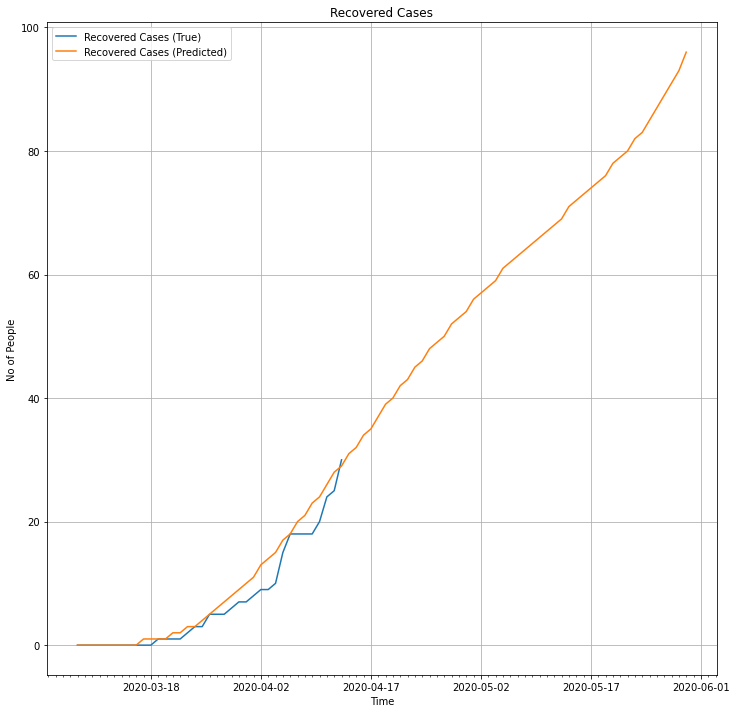

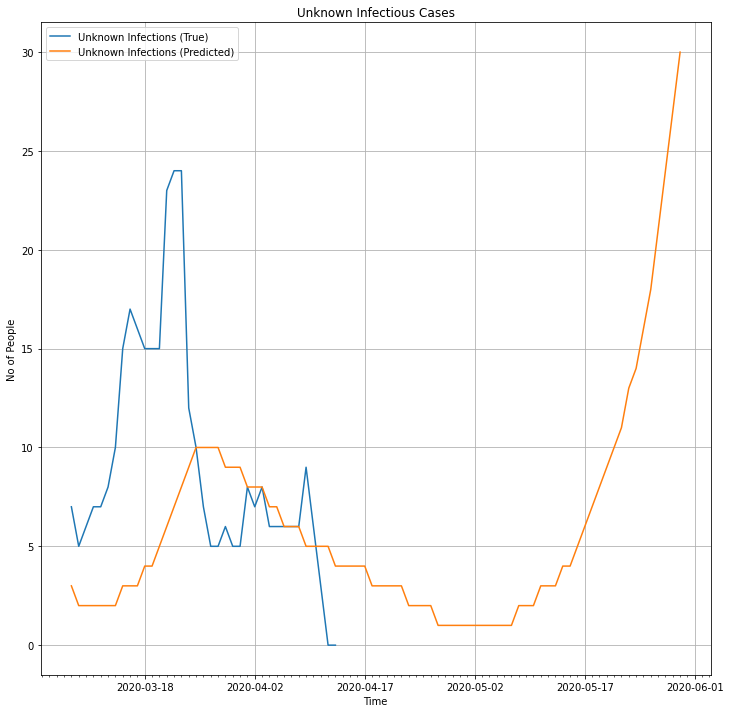

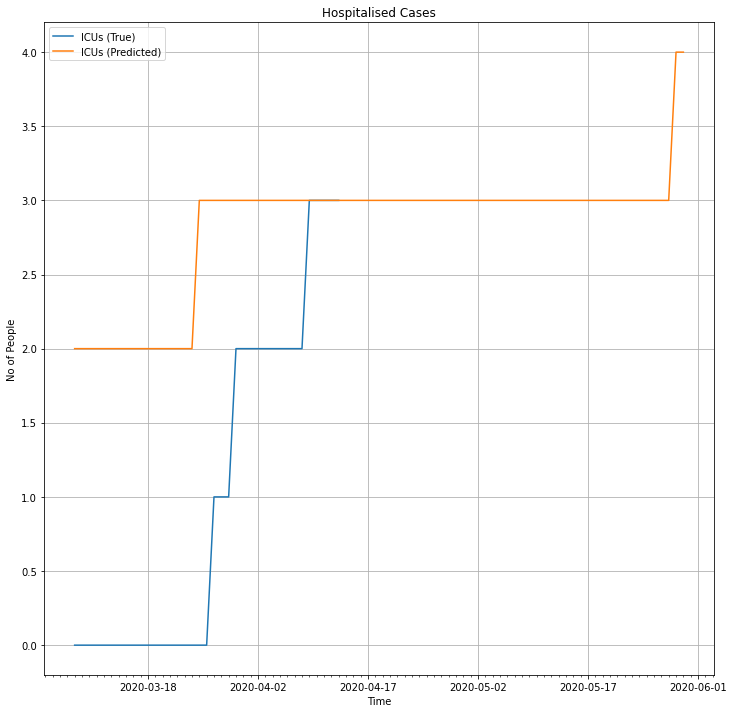

In [199]:
start_date = df_train.iloc[0, 0]
simulate_till = df_val.iloc[-1, 0]
simulate_till = datetime.datetime.strptime('2020-05-30', '%Y-%m-%d')

lockdown_removal_date = datetime.datetime.strptime('2020-05-03', '%Y-%m-%d')
default_params['lockdown_removal_day'] = (lockdown_removal_date - start_date).days

df_country = df_agg
total_no_of_days = (simulate_till - start_date).days + 1
prediction_daterange = pd.date_range(start=start_date, end=simulate_till)

final_params = {**best3, **default_params}
vanilla_params, testing_params, state_init_values = init_params(**final_params)
solver = SEIR_Testing(vanilla_params, testing_params, state_init_values)
sol = solver.solve_ode(total_no_of_days=total_no_of_days - 1, time_step=1, method='Radau')
states_time_matrix = (sol.y*vanilla_params['N']).astype('int')

pred_hospitalisations = states_time_matrix[6] + states_time_matrix[7] + states_time_matrix[8]
pred_recoveries = states_time_matrix[9]
pred_fatalities = states_time_matrix[10]
pred_infectious_unknown = states_time_matrix[2] + states_time_matrix[4]
pred_total_cases = pred_hospitalisations + pred_recoveries + pred_fatalities

train_start = datetime.datetime.strptime('2020-03-25', '%Y-%m-%d')
test_start = datetime.datetime.strptime('2020-04-04', '%Y-%m-%d')
test_end = datetime.datetime.strptime('2020-04-13', '%Y-%m-%d')

fig, ax = plt.subplots(figsize=(12, 12))
ax.plot(df_country['Date'], df_country['Total Infected'], label='Confirmed Cases (True)')
ax.plot(prediction_daterange, pred_total_cases, label='Confirmed Cases (Predicted)')
# ax.plot([train_start, train_start], [min(df_country['Total Infected']), max(df_country['Total Infected'])], '--r', label='Train Start')
# ax.plot([test_start, test_start], [min(df_country['Total Infected']), max(df_country['Total Infected'])], '--g', label='Test Start')
# ax.plot([test_end, test_end], [min(df_country['Total Infected']), max(df_country['Total Infected'])], '--g', label='Test End')
# sns.lineplot(x=df_predictions["Date"], y=df_predictions["total_cases"], ci='sd', label='Lockdown 30-04 (Predicted)')
# sns.lineplot(x=df_predictions1["Date"], y=df_predictions1["total_cases"], ci='sd', label='Lockdown 14-04 (Predicted)')
# sns.lineplot(x=df_predictions2["Date"], y=df_predictions2["total_cases"], ci='sd', label='Lockdown 15-05 (Predicted)')
ax.xaxis.set_major_locator(mdates.DayLocator(interval=15))
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.ylabel('No of People')
plt.xlabel('Time')
plt.legend()
plt.title('Total Confirmed Cases')
plt.grid()
plt.show()

fig, ax = plt.subplots(figsize=(12, 12))
ax.plot(df_country['Date'], df_country['Hospitalised'], label='Hospitalisations (True)')
ax.plot(prediction_daterange, pred_hospitalisations, label='Hospitalisations (Predicted)')
# ax.plot([train_start, train_start], [min(df_country['Hospitalised']), max(df_country['Hospitalised'])], '--r', label='Train Start')
# ax.plot([test_start, test_start], [min(df_country['Hospitalised']), max(df_country['Hospitalised'])], '--g', label='Test Start')
# ax.plot([test_end, test_end], [min(df_country['Hospitalised']), max(df_country['Hospitalised'])], '--g', label='Test End')
# sns.lineplot(x=df_predictions["Date"], y=df_predictions["hospitalised"], ci='sd', label='Lockdown 30-04 (Predicted)')
# sns.lineplot(x=df_predictions1["Date"], y=df_predictions1["hospitalised"], ci='sd', label='Lockdown 14-04 (Predicted)')
# sns.lineplot(x=df_predictions2["Date"], y=df_predictions2["hospitalised"], ci='sd', label='Lockdown 15-05 (Predicted)')
ax.xaxis.set_major_locator(mdates.DayLocator(interval=15))
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.ylabel('No of People')
plt.xlabel('Time')
plt.legend()
plt.title('Hospitalised Cases')
plt.grid()
plt.show()

fig, ax = plt.subplots(figsize=(12, 12))
ax.plot(df_country['Date'], df_country['Recovered'], label='Recovered Cases (True)')
ax.plot(prediction_daterange, pred_recoveries, label='Recovered Cases (Predicted)')
# ax.plot([train_start, train_start], [min(df_country['Recovered']), max(df_country['Recovered'])], '--r', label='Train Start')
# ax.plot([test_start, test_start], [min(df_country['Recovered']), max(df_country['Recovered'])], '--g', label='Test Start')
# ax.plot([test_end, test_end], [min(df_country['Recovered']), max(df_country['Recovered'])], '--g', label='Test End')
# sns.lineplot(x=df_predictions["Date"], y=df_predictions["recoveries"], ci='sd', label='Recovered Cases (Predicted)')
# sns.lineplot(x=df_predictions1["Date"], y=df_predictions1["recoveries"], ci='sd', label='Lockdown 14-04 (Predicted)')
ax.xaxis.set_major_locator(mdates.DayLocator(interval=15))
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.ylabel('No of People')
plt.xlabel('Time')
plt.legend()
plt.title('Recovered Cases')
plt.grid()
plt.show()

fig, ax = plt.subplots(figsize=(12, 12))
ax.plot(df_country['Date'], df_country['Active Infections (Unknown)'], label='Unknown Infections (True)')
ax.plot(prediction_daterange, pred_infectious_unknown, label='Unknown Infections (Predicted)')
# ax.plot([train_start, train_start], [min(df_country['Active Infections (Unknown)']), max(df_country['Active Infections (Unknown)'])], '--r', label='Train Start')
# ax.plot([test_start, test_start], [min(df_country['Active Infections (Unknown)']), max(df_country['Active Infections (Unknown)'])], '--g', label='Test Start')
# ax.plot([test_end, test_end], [min(df_country['Active Infections (Unknown)']), max(df_country['Active Infections (Unknown)'])], '--g', label='Test End')
# sns.lineplot(x=df_predictions["Date"], y=df_predictions["infectious_unknown"], ci='sd', label='Unknown Infections (Predicted)')
# sns.lineplot(x=df_predictions1["Date"], y=df_predictions1["infectious_unknown"], ci='sd', label='Lockdown 14-04 (Predicted)')
ax.xaxis.set_major_locator(mdates.DayLocator(interval=15))
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.ylabel('No of People')
plt.xlabel('Time')
plt.legend()
plt.title('Unknown Infectious Cases')
plt.grid()
plt.show()

fig, ax = plt.subplots(figsize=(12, 12))
ax.plot(df_country['Date'], df_country['On ICU'], label='ICUs (True)')
pred_icus = 3 + 0.02*(pred_hospitalisations - df_agg.iloc[-1, :]['Hospitalised'])
pred_icus = list(map(lambda x : round(x), pred_icus))
ax.plot(prediction_daterange, pred_icus, label='ICUs (Predicted)')
# ax.plot([train_start, train_start], [min(df_country['Hospitalised']), max(df_country['Hospitalised'])], '--r', label='Train Start')
# ax.plot([test_start, test_start], [min(df_country['Hospitalised']), max(df_country['Hospitalised'])], '--g', label='Test Start')
# ax.plot([test_end, test_end], [min(df_country['Hospitalised']), max(df_country['Hospitalised'])], '--g', label='Test End')
# sns.lineplot(x=df_predictions["Date"], y=df_predictions["hospitalised"], ci='sd', label='Lockdown 30-04 (Predicted)')
# sns.lineplot(x=df_predictions1["Date"], y=df_predictions1["hospitalised"], ci='sd', label='Lockdown 14-04 (Predicted)')
# sns.lineplot(x=df_predictions2["Date"], y=df_predictions2["hospitalised"], ci='sd', label='Lockdown 15-05 (Predicted)')
ax.xaxis.set_major_locator(mdates.DayLocator(interval=15))
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.ylabel('No of People')
plt.xlabel('Time')
plt.legend()
plt.title('Hospitalised Cases')
plt.grid()
plt.show()


In [247]:
start_date = df_train.iloc[0, 0]
simulate_till = df_val.iloc[-1, 0]
simulate_till = datetime.datetime.strptime('2020-07-31', '%Y-%m-%d')

lockdown_removal_date = datetime.datetime.strptime('2020-05-03', '%Y-%m-%d')
default_params['lockdown_removal_day'] = (lockdown_removal_date - start_date).days
default_params['P_fatal'] = 0.03
default_params['P_severe'] = 0.97

df_country = df_agg
total_no_of_days = (simulate_till - start_date).days + 1
prediction_daterange = pd.date_range(start=start_date, end=simulate_till)
no_of_predictions = len(prediction_daterange)

columns = ['forecastRunDate', 'regionType', 'region', 'model_name', 'error_function', 'error_value', 'current_active', 'current_recovered', 
           'current_deceased', 'current_hosptialized', 'current_icu', 'current_ventilator', 'predictionDate', 'active_mean', 'active_min', 
           'active_max', 'hospitalized_mean', 'hospitalized_min', 'hospitalized_max', 'icu_mean', 'icu_min', 'icu_max', 'deceased_mean', 
           'deceased_min', 'deceased_max', 'recovered_mean', 'recovered_min', 'recovered_max', 'total_mean', 'total_min', 'total_max']

df_output = pd.DataFrame(columns = columns)

df_output['predictionDate'] = prediction_daterange
df_output['forecastRunDate'] = [datetime.datetime.today().date()]*no_of_predictions
df_output['regionType'] = ['city']*no_of_predictions
df_output['region'] = ['bengaluru']*no_of_predictions
df_output['model_name'] = ['SEIR']*no_of_predictions
df_output['error_function'] = ['MAPE']*no_of_predictions
df_output['error_value'] = [val_losses.loc['total', 'mape']]*no_of_predictions

final_params = {**best3, **default_params}
vanilla_params, testing_params, state_init_values = init_params(**final_params)
solver = SEIR_Testing(vanilla_params, testing_params, state_init_values)
sol = solver.solve_ode(total_no_of_days=total_no_of_days - 1, time_step=1, method='Radau')
states_time_matrix = (sol.y*vanilla_params['N']).astype('int')

pred_hospitalisations = states_time_matrix[6] + states_time_matrix[7] + states_time_matrix[8]
df_output['active_mean'] = pred_hospitalisations
df_output['active_min'] = (1 - 0.01*val_losses.loc['hospitalised', 'mape'])*pred_hospitalisations
df_output['active_max'] = (1 + 0.01*val_losses.loc['hospitalised', 'mape'])*pred_hospitalisations

df_output['hospitalized_mean'] = pred_hospitalisations
df_output['hospitalized_min'] = (1 - 0.01*val_losses.loc['hospitalised', 'mape'])*pred_hospitalisations
df_output['hospitalized_max'] = (1 + 0.01*val_losses.loc['hospitalised', 'mape'])*pred_hospitalisations

df_output['icu_mean'] = list(map(lambda x : round(x), 3 + 0.02*(pred_hospitalisations - df_agg.iloc[-1, :]['Hospitalised']) ))
df_output['icu_min'] = list(map(lambda x : round(x), 3 + 0.02*(df_output['hospitalized_min'] - df_agg.iloc[-1, :]['Hospitalised']) ))
df_output['icu_max'] = list(map(lambda x : round(x), 3 + 0.02*(df_output['hospitalized_max'] - df_agg.iloc[-1, :]['Hospitalised']) ))

pred_recoveries = states_time_matrix[9]
df_output['recovered_mean'] = pred_recoveries
df_output['recovered_min'] = (1 - 0.01*val_losses.loc['recovered', 'mape'])*pred_recoveries
df_output['recovered_max'] = (1 + 0.01*val_losses.loc['recovered', 'mape'])*pred_recoveries

pred_fatalities = states_time_matrix[10]
df_output['deceased_mean'] = pred_fatalities
df_output['deceased_min'] = (1 - 0.01*val_losses.loc['fatalities', 'mape'])*pred_fatalities
df_output['deceased_max'] = (1 + 0.01*val_losses.loc['fatalities', 'mape'])*pred_fatalities

pred_infectious_unknown = states_time_matrix[2] + states_time_matrix[4]
pred_total_cases = pred_hospitalisations + pred_recoveries + pred_fatalities
df_output['total_mean'] = pred_total_cases
df_output['total_min'] = (1 - 0.01*val_losses.loc['total', 'mape'])*pred_total_cases
df_output['total_max'] = (1 + 0.01*val_losses.loc['total', 'mape'])*pred_total_cases

df_output.set_index('predictionDate', inplace=True)
df_output.loc[df_output.index.isin(df_agg['Date']), 'current_active'] = df_agg['Hospitalised'].to_numpy()
df_output.loc[df_output.index.isin(df_agg['Date']), 'current_recovered'] = df_agg['Recovered'].to_numpy()
df_output.loc[df_output.index.isin(df_agg['Date']), 'current_deceased'] = df_agg['Fatalities'].to_numpy()
df_output.loc[df_output.index.isin(df_agg['Date']), 'current_hosptialized'] = df_agg['Hospitalised'].to_numpy()
df_output.loc[df_output.index.isin(df_agg['Date']), 'current_icu'] = df_agg['On ICU'].to_numpy()
df_output.loc[df_output.index.isin(df_agg['Date']), 'current_ventilator'] = df_agg['On Ventilator'].to_numpy()
df_output.reset_index(inplace=True)
df_output = df_output[columns]

In [248]:
# df_output.to_csv('../../output.csv')
df_output

,forecastRunDate,regionType,region,model_name,error_function,error_value,current_active,current_recovered,current_deceased,current_hosptialized,...,icu_max,deceased_mean,deceased_min,deceased_max,recovered_mean,recovered_min,recovered_max,total_mean,total_min,total_max
0,2020-04-15,city,bengaluru,SEIR,MAPE,3.308668,3,0,0,3,...,2,0,0.0,0.0,0,0.000000,0.000000,0,0.000000,0.000000
1,2020-04-15,city,bengaluru,SEIR,MAPE,3.308668,4,0,0,4,...,2,0,0.0,0.0,0,0.000000,0.000000,0,0.000000,0.000000
2,2020-04-15,city,bengaluru,SEIR,MAPE,3.308668,4,0,0,4,...,2,0,0.0,0.0,0,0.000000,0.000000,1,0.966913,1.033087
3,2020-04-15,city,bengaluru,SEIR,MAPE,3.308668,5,0,0,5,...,2,0,0.0,0.0,0,0.000000,0.000000,2,1.933827,2.066173
4,2020-04-15,city,bengaluru,SEIR,MAPE,3.308668,5,0,0,5,...,2,0,0.0,0.0,0,0.000000,0.000000,2,1.933827,2.066173
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,2020-04-15,city,bengaluru,SEIR,MAPE,3.308668,NaN,NaN,NaN,NaN,...,1337,483,0.0,966.0,17121,14337.886333,19904.113667,78492,75894.960421,81089.039579
142,2020-04-15,city,bengaluru,SEIR,MAPE,3.308668,NaN,NaN,NaN,NaN,...,1508,545,0.0,1090.0,19317,16176.914333,22457.085667,88543,85613.406214,91472.593786
143,2020-04-15,city,bengaluru,SEIR,MAPE,3.308668,NaN,NaN,NaN,NaN,...,1700,615,0.0,1230.0,21797,18253.776556,25340.223444,99878,96573.368711,103182.631289
144,2020-04-15,city,bengaluru,SEIR,MAPE,3.308668,NaN,NaN,NaN,NaN,...,1918,694,0.0,1388.0,24598,20599.458444,28596.541556,112660,108932.454785,116387.545215


In [249]:
df_output['hospitalized_mean']

0          0
1          0
2          1
3          2
4          2
       ...  
141    60888
142    68681
143    77466
144    87368
145    98506
Name: hospitalized_mean, Length: 146, dtype: int64

In [244]:
final_params = {**best2, **default_params}
vanilla_params, testing_params, state_init_values = init_params(**final_params)
solver = SEIR_Testing(vanilla_params, testing_params, state_init_values)
sol = solver.solve_ode(total_no_of_days=total_no_of_days - 1, time_step=1, method='Radau')
states_time_matrix = (sol.y*vanilla_params['N']).astype('int')

pred_hospitalisations = states_time_matrix[6] + states_time_matrix[7] + states_time_matrix[8]
df_output['active_mean'] = pred_hospitalisations
df_output['active_min'] = (1 - 0.01*val_losses.loc['hospitalised', 'mape'])*pred_hospitalisations
df_output['active_max'] = (1 + 0.01*val_losses.loc['hospitalised', 'mape'])*pred_hospitalisations

df_output['hospitalized_mean'] = pred_hospitalisations
df_output['hospitalized_min'] = (1 - 0.01*val_losses.loc['hospitalised', 'mape'])*pred_hospitalisations
df_output['hospitalized_max'] = (1 + 0.01*val_losses.loc['hospitalised', 'mape'])*pred_hospitalisations

In [245]:
df_output['hospitalized_mean']

0           0
1           0
2           1
3           2
4           2
        ...  
141    134220
142    152414
143    172970
144    196189
145    222383
Name: hospitalized_mean, Length: 146, dtype: int64

In [250]:
df_output.to_csv('../../output.csv', index=False)